# Transfer the model trained in MNIST datasets to EMNIST datasets
### Difference between MNIST and EMNIST:
MNIST consists of 0-9 numbers, while EMNIST contains an additional 26 English letters. 
I have saved a model trained by MNIST datasets, and in this notebook I load it and keep its convolutional layers' parameters constant. I just train the last linear layer and change its output size into 26 which matches the number of classes(26 English letters).

In [1]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5,],std=[0.5,])])

data_train=datasets.EMNIST(root='data/',split = 'letters', transform=transform,train=True,download=True)
data_test=datasets.EMNIST(root='data/',split = 'letters',transform=transform,train=False)

D:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
data_loader_train = torch.utils.data.DataLoader(data_train, batch_size = 64, shuffle = True)
data_loader_test = torch.utils.data.DataLoader(data_test, batch_size = 64, shuffle = True)

torch.Size([64, 1, 28, 28])
torch.Size([3, 242, 242])
after transpose shape: (242, 242, 3)
[tensor(6), tensor(25), tensor(24), tensor(12), tensor(23), tensor(10), tensor(23), tensor(8), tensor(18), tensor(16), tensor(16), tensor(18), tensor(12), tensor(26), tensor(4), tensor(16)]
[tensor(6), tensor(25), tensor(24), tensor(12), tensor(23), tensor(10), tensor(23), tensor(8), tensor(18), tensor(16), tensor(16), tensor(18), tensor(12), tensor(26), tensor(4), tensor(16)]
tensor(26)
tensor(1)


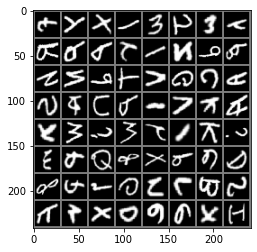

In [4]:
images,labels=next(iter(data_loader_train))
# Splicing the 64 pictures into one picture to see what the pictures look like
print(images.shape)
img=torchvision.utils.make_grid(images)
print(img.shape)
# transpose the img because imshow need a img construction of (height,weight,channel) 
# but img has a construction of (channel,height,weight)

img=img.numpy().transpose(1,2,0)

print("after transpose shape:",img.shape)
# Gray stretch
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i].data for i in range(16)])


print([labels[i].data for i in range(16)])
print(labels.data.max())
print(labels.data.min())
plt.imshow(img)
plt.show()


In [5]:
# origin shape of image is (1,28,28)
class CNN_Net(torch.nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            # Convolution change to (64,28,28)
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            # Maxpooling change to (64,14,14)
            torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.conv2=torch.nn.Sequential(
            # Convolution change to (128,14,14)
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            # Maxpooling change to (128,7,7)
            torch.nn.MaxPool2d(stride=2, kernel_size=2))
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(128 * 7 * 7, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024, 10))

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        # change the size to one column to match the linear layer
        x = x2.view(-1, 128 * 7 * 7)
        x = self.dense(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# load the model which had been trained by MNIST datasets
CNN_NET = torch.load('data/cnn_by_MNIST.pt')
cnn_net = CNN_NET
print(cnn_net)

CNN_Net(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [10]:
# Do not train the data
for param in cnn_net.parameters():
    param.requires_grad = False

In [11]:
# Just change the last linear layer because EMNIST has 26 classes,and train the last layer's parameters
cnn_net.dense[3] = torch.nn.Linear(1024, 26)
for param in cnn_net.dense[3].parameters():

    param.requires_grad = True

In [12]:

# use GPU to accelerate
if torch.cuda.is_available():
    cnn_net = cnn_net.cuda()

# CrossEntropy = softmax + log + NLL loss

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_net.dense[3].parameters(),lr=0.001)

def train(model):
    for data in data_loader_train:
        x_train, y_train = data
        t = torch.tensor(1)
        y_train = y_train -t
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_hat = model(x_train)
        loss = loss_func(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch %d, loss %.4f' % (epoch + 1, loss))
    return loss  

In [13]:
def test(model):
    correct = 0
    for data in data_loader_test:
        x_test, y_test = data
        t = torch.tensor(1)
        y_test = y_test -t
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        with torch.no_grad():
            outputs = model(x_test)
        
        _, predict = torch.max(outputs.data, dim=1)
        correct += torch.sum(predict == y_test.data)
    correct = correct.detach().cpu().numpy()
    print("correct rate = ",100 * correct/len(data_test))
    return 100 * correct/len(data_test) *0.01

epoch 1, loss 1.0515
correct rate =  74.51442307692308
epoch 2, loss 0.8190
correct rate =  74.6923076923077
epoch 3, loss 1.0471
correct rate =  74.1826923076923
epoch 4, loss 0.9440
correct rate =  75.01923076923077
epoch 5, loss 0.7168
correct rate =  74.40384615384616
epoch 6, loss 0.6224
correct rate =  74.46153846153847
epoch 7, loss 0.5916
correct rate =  74.34615384615384
epoch 8, loss 0.8310
correct rate =  74.42307692307692
epoch 9, loss 0.9107
correct rate =  74.24038461538461
epoch 10, loss 0.5215
correct rate =  74.48557692307692


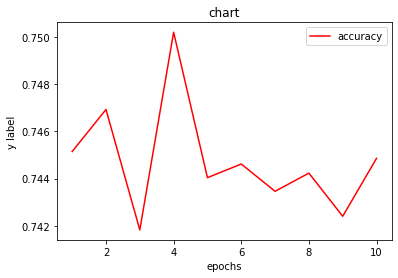

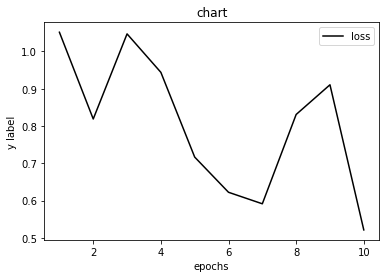

In [20]:
lss = []
acc = []
epochs = []
for epoch in range(10):
    epochs.append(epoch+1)
    ls = train(cnn_net);
    ac = test(cnn_net);
    l_tmp = ls.detach().cpu().numpy()
    lss.append(l_tmp)
    acc.append(ac);
    
plt.plot(epochs,acc,color='r',label='accuracy')  
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()   
plt.show()

plt.plot(epochs,lss,color=(0,0,0),label='loss')
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()            
plt.show()

#
We can see that the transfer model's performance on EMNIST is just so so. It has an average correct rate of about 75%.

Then I will train an origin model to see the difference.

In [14]:
# create an origin cnn model
cnn_net_origin = CNN_Net()
# change the last linear layer
cnn_net_origin.dense[3] = torch.nn.Linear(1024, 26)

D:\anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 1, loss 0.3561
correct rate =  87.76923076923077
epoch 2, loss 0.2957
correct rate =  90.4326923076923
epoch 3, loss 0.3207
correct rate =  91.70673076923077
epoch 4, loss 0.2435
correct rate =  92.39423076923077
epoch 5, loss 0.1385
correct rate =  92.57211538461539
epoch 6, loss 0.1770
correct rate =  92.66826923076923
epoch 7, loss 0.1226
correct rate =  92.88461538461539
epoch 8, loss 0.4656
correct rate =  93.07692307692308
epoch 9, loss 0.1253
correct rate =  93.09134615384616
epoch 10, loss 0.1295
correct rate =  93.03846153846153


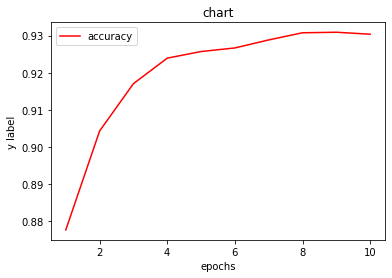

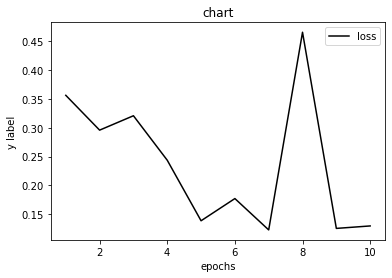

In [15]:

# use GPU to accelerate
if torch.cuda.is_available():
    cnn_net_origin = cnn_net_origin.cuda()

# CrossEntropy = softmax + log + NLL loss

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_net_origin.parameters(),lr=0.001)

lss = []
acc = []
epochs = []
for epoch in range(10):
    epochs.append(epoch+1)
    ls = train(cnn_net_origin);
    ac = test(cnn_net_origin);
    l_tmp = ls.detach().cpu().numpy()
    lss.append(l_tmp)
    acc.append(ac);
    
plt.plot(epochs,acc,color='r',label='accuracy')  
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()   
plt.show()

plt.plot(epochs,lss,color=(0,0,0),label='loss')
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()            
plt.show()

#
After 10 epoches of training, the correct rate becomes stable around 93%. The difference of correct rate between the original model and the transfer model is just about 18%. So transfer model is effective to a certain extent.